# **Value-at-Risk (VaR) Estimator (Work In Progress)**

## **Contents**
1. [Introduction](#Introduction)
2. [Risk Functions](#Risk-Functions)
   * [Value-at-Risk (VaR)](#Value-at-Risk-(VaR))
   * [Expected Shortfall (ES)](#Expected-Shortfall-(ES))
   * [Range Value-at-Risk (RVaR)](#Range-Value-at-Risk-(RVaR))
3. [Historical Method](#Historical-Method)
   * [Application of the Historical Method](#Application-of-the-Historical-Method)
   * [Python Implementation of the Historical-Method](#Python-Implementation-of-the-Historical-Method)
4. [Parametric Method](#Parametric-Method)
   * [Application of the Parametric Method](#Application-of-the-Parametric-Method)
   * [Python Implementation of the Parametric Method](#Python-Implementation-of-the-Parametric-Method)
5. [Monte Carlo Method](#Monte-Carlo-Method)
   * [Application of the Parametric Method](#Application-of-the-Parametric-Method)
   * [Python Implementation of the Parametric Method](#Python-Implementation-of-the-Parametric-Method)
6. [Credits](#Credits)

## **Introduction**
The purpose of this project is to provide a method to immediately estimate, using Python, the Value-at-Risk (VaR), and related risk functions, of a portfolio of risk-bearing assets. The `time`, `datetime`, `numpy`, `scipy`, `sympy`, `pandas`, `matplotlib`, `seaborn`, `yfinance`, `pypfopt`, `riskfolio` and `warnings` libraries will be imported. Moreover, a random seed value is set for reprodicibility and the plot styles are modified for aesthetic reasons.

In [68]:
import time as tm
import datetime as dt
import numpy as np
import scipy as sp
import sympy as smp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pypfopt as ppf
import riskfolio as rsk
import warnings as wrn

np.random.seed(30)
palette = sns.color_palette("viridis_r", as_cmap=True)
sns.set_style(style = "whitegrid", rc = {"font.family":"Times New Roman", "font.weight":"bold"})
wrn.simplefilter(action='ignore', category=FutureWarning)

tickers = ["MSFT", "AAPL"]
start_date = "2018-01-01"
end_date = "2024-01-01"
N = len(tickers)
weights = np.ones(N) / N
alpha = 0.05
beta = 0.01
show_performance_metrics = True
show_visualizations = True
data = yf.download(tickers, start_date, end_date, progress = False)["Adj Close"]

## **Risk Functions**
Let $\left(\Omega, \mathscr{F}, \mathbb{P}\right)$ be a probability space, let $(\mu, \sigma)$ be an ordered pair in $\mathbb{R}^{*} \times \mathbb{R}_{+}^{*}$, let $(S_{t})_{t \in \mathbb{R}_{+}}$ be a geometric Brownian motion with percentage drift $\mu$ and percentage volatility $\sigma$ on $\left(\Omega, \mathscr{F}, \mathbb{P}\right)$ such that $S_{0} \substack{\mathbb{P}\text{-a.s.} \\ \neq} 0$ and let $(h, \alpha)$ be an ordered pair in $\mathbb{R}_{+}^{*} \times ]0,1[$.
- The *profit-and-loss distribution of $(S_{t})_{t \in \mathbb{R}_{+}}$ at horizon $h$* is the stochastic process denoted by $(L_{t, h})_{t \in \mathbb{R}_{+}}$ and defined by:
$$\forall (\omega, t) \in \Omega \times \mathbb{R}_{+}, \enspace L_{t, h}(\omega) = S_{t + h}(\omega) - S_{t}(\omega)$$
- The *relative return distribution of $(S_{t})_{t \in \mathbb{R}_{+}}$ at horizon $h$* is the stochastic process denoted by $(R_{t, h})_{t \in \mathbb{R}_{+}}$ and defined by:
$$\forall (\omega, t) \in \Omega \times \mathbb{R}_{+}, \enspace R_{t, h}(\omega) = \frac{S_{t + h}(\omega) - S_{t}(\omega)}{S_{t}(\omega)}$$
Here, the stochastic process $(S_{t})_{t \in \mathbb{R}_{+}}$ can represent the price of a single risk-bearing financial asset, or the overall value of a portfolio of risk-bearning financial asset.

### **Value-at-Risk (VaR)**
For every positive real number $t$ in $\mathbb{R}_{+}$ the *Value-at-Risk (VaR) of $S_{t}$ at siginificance level $\alpha$ and horizon $h$* is the real number denoted by $\mathrm{VaR}_{\alpha, h}\left(S_{t}\right)$ and defined by:
$$\mathrm{VaR}_{\alpha, h}\left(S_{t}\right) = -\inf\left(\left\{x \in \mathbb{R} \colon \enspace F_{L_{t, h}}(x) > \alpha\right\}\right)$$

### **Expected Shortfall (ES)**
For every positive real number $t$ in $\mathbb{R}_{+}$ the *Expected Shortfall (ES) of $S_{t}$ at siginificance level $\alpha$ and horizon $h$* is the real number denoted by $\mathrm{ES}_{\alpha, h}\left(S_{t}\right)$ and defined by:
$$\mathrm{ES}_{\alpha, h}\left(S_{t}\right) = -\frac{1}{\alpha}\int_{0}^{\alpha}\mathrm{VaR}_{\gamma, h}\left(S_{t}\right)\mathrm{d}\gamma$$
The expected shortfall is also called the Conditional Value-at-Risk (CVaR).


### **Range Value-at-Risk (RVaR)**
Let $\beta$ be a strictly positive real number in $]0,1[$ such that $\alpha > \beta$. For every positive real number $t$ in $\mathbb{R}_{+}$ the *Range Value-at-Risk of $S_{t}$ between siginificance levels $\beta$ and $\alpha$ and at horizon $h$* is the real number denoted by $\mathrm{RVaR}_{\alpha, \beta, h}\left(S_{t}\right)$ and defined by:
$$\mathrm{RVaR}_{\alpha, \beta, h}\left(S_{t}\right) = -\frac{1}{\alpha - \beta}\int_{\beta}^{\alpha}\mathrm{VaR}_{\gamma, h}\left(S_{t}\right)\mathrm{d}\gamma$$

One property that these risk functions share is the following inequality:
$$\mathrm{VaR}_{\alpha, h}\left(S_{t}\right) \leqslant \mathrm{RVaR}_{\alpha, \beta, h}\left(S_{t}\right) \leqslant \mathrm{ES}_{\alpha, h}(S_{t})$$
which is guaranteed to hold true provided that the moment generating function $\mathbf{M}_{S_{t}}$ of the random variable $S_{t}$ exists and is well-defined. 

In most cases, the exact values of each of the above three risk functions cannot be calculated directly. There are, however, three methods that stand out in calculating each of them: 
- The historical method (which estimates the values of the risk functions from the quantiles of past data of the profit-and-loss distribution of the underlying geometric Brownian motion);
- The parametric method (which estimates the values of the risk functions from the parameters of the distribution of past data of the profit-and-loss distribution of the underlying geometric Brownian motion), and;
- The Monte Carlo method (which estimates the values of the risk functions by repeated random sampling from the distribution of past data of the profit-and-loss distribution of the underlying geometric Brownian motion).

The details of each of the above three methods, as well as their Python implementation, is given in the following sections.

## **Historical Method**
### **Application of the Historical Method**
The following is a general procedure for estimating the risk functions via the historical method:
1. Retrieve the historical price data of the underlying asset or portfolio of assets, the frequency being the time horizon of choice;
2. Calculate the profit-and-loss distribution corresponding to this historical price data;
3. Determine the relevant estimates of the values of the risk functions as follows:
   * In order to calculate $\mathrm{VaR}_{\alpha, h}(S_{t})$, select the negative of the $\alpha$-quantile of the profit-and-loss distribution.
   * In order to calculate $\mathrm{ES}_{\alpha, h}(S_{t})$, calculate the negative of the mean of all values in the profit-and-loss distribution not exceeding its $\alpha$-quantile.
   * In order to calculate $\mathrm{RVaR}_{\alpha, \beta, h}(S_{t})$, calculate the negative of the mean of all values in the profit-and-loss distribution not between its $\alpha$-quantile and its $\beta$-quantile.
The historical method makes no *a priori* assumption about the profit-and-loss distribution. It only retireves the quantiles of interest.

### **Python Implementation of the Historical Method**
#### **Python Implementation of the Historical Value-at-Risk**
The Python implementation of the historical method for estimating the Historical Value-at-Risk is given in the code cell below.

Position size at 2024-01-01: 283.82 units of local currency
Significance level: α = 0.05
Time horizon: 1 day
Estimated VaR: 4.64 units of local currency
Estimated VaR-deducted portfolio value at 2024-01-01: 279.18 units of local currency
Computation time: 0.000 seconds


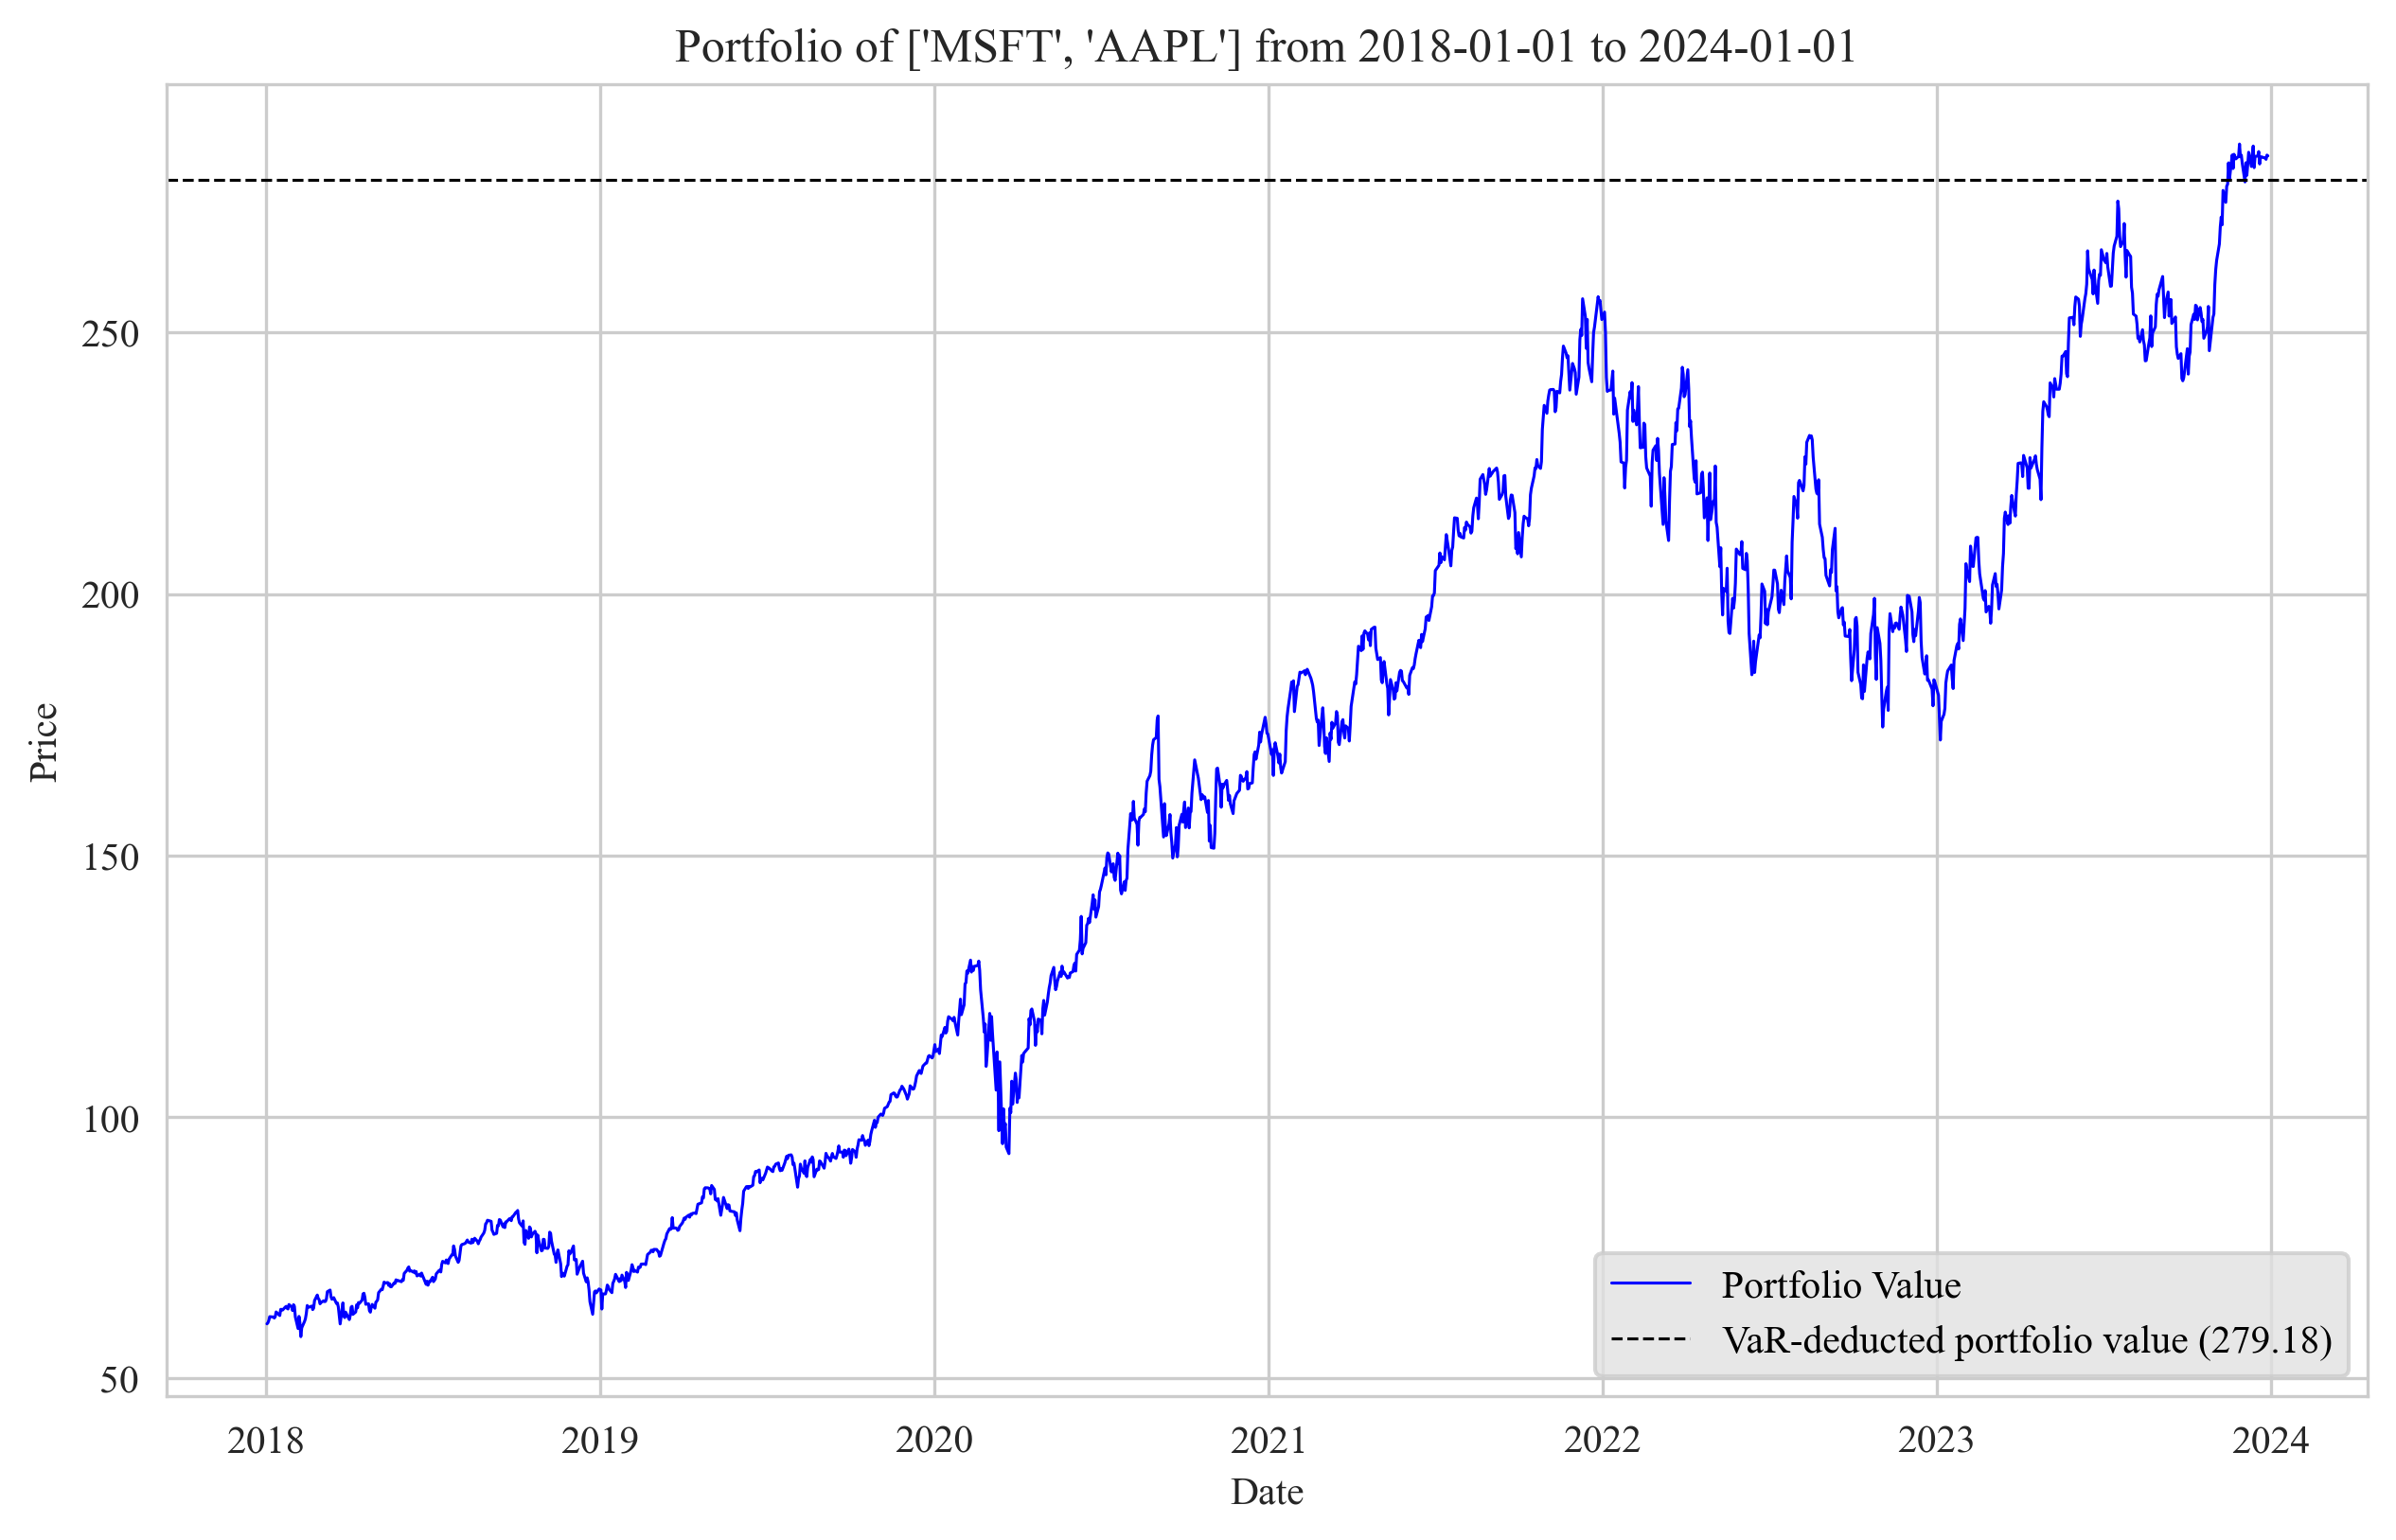

In [69]:
def Historical_VaR(tickers, start_date, end_date, weights, alpha, show_performance_metrics = False, show_visualizations = False):
    assert (0 < alpha < 1) and type(len(tickers)) is int
    data = yf.download(tickers, start_date, end_date, progress = False)["Adj Close"]
    start = tm.time()
    data["Portfolio"] = np.dot(weights, data.T)
    portfolio = data["Portfolio"]
    PnL = data["Portfolio"].diff().dropna()
    VaR = -np.quantile(PnL, alpha)
    end = tm.time()
    if show_performance_metrics:
        position = portfolio[-1]
        VaR_position = position - VaR
        computation_time = end - start
        print(f"Position size at {end_date}: {position:.2f} units of local currency")
        print(f"Significance level: \u03B1 = {alpha}")
        print(f"Time horizon: 1 day")
        print(f"Estimated VaR: {VaR:.2f} units of local currency")
        print(f"Estimated VaR-deducted portfolio value at {end_date}: {VaR_position:.2f} units of local currency")
        print(f"Computation time: {computation_time:.3f} seconds")
    else:
        pass
    if show_visualizations:
        fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
        sns.lineplot(data = portfolio, linewidth = 0.75, color = "b", label = "Portfolio Value").set(xlabel = "Date", ylabel = "Price")
        plt.axhline(VaR_position, color = "black", linestyle = "--", linewidth = 0.75, label = f"VaR-deducted portfolio value ({VaR_position:.2f})")
        plt.legend(labelcolor = "black", facecolor = "#E1E1E1")
        plt.title(f"Portfolio of {tickers} from {start_date} to {end_date}")
        plt.show()
    else:
        pass
    return VaR

VaR = Historical_VaR(tickers, start_date, end_date, weights, alpha, show_performance_metrics, show_visualizations)

#### **Python Implementation of the Historical Expected Shortfall**
The Python implementation of the historical method for estimating the Historical Expected Shortfall is given in the code cell below.

Position size at 2024-01-01: 283.82 units of local currency
Significance level: α = 0.05
Time horizon: 1 day
Estimated ES: 6.49 units of local currency
Estimated ES-deducted portfolio value at 2024-01-01: 277.32 units of local currency
Computation time: 0.000 seconds


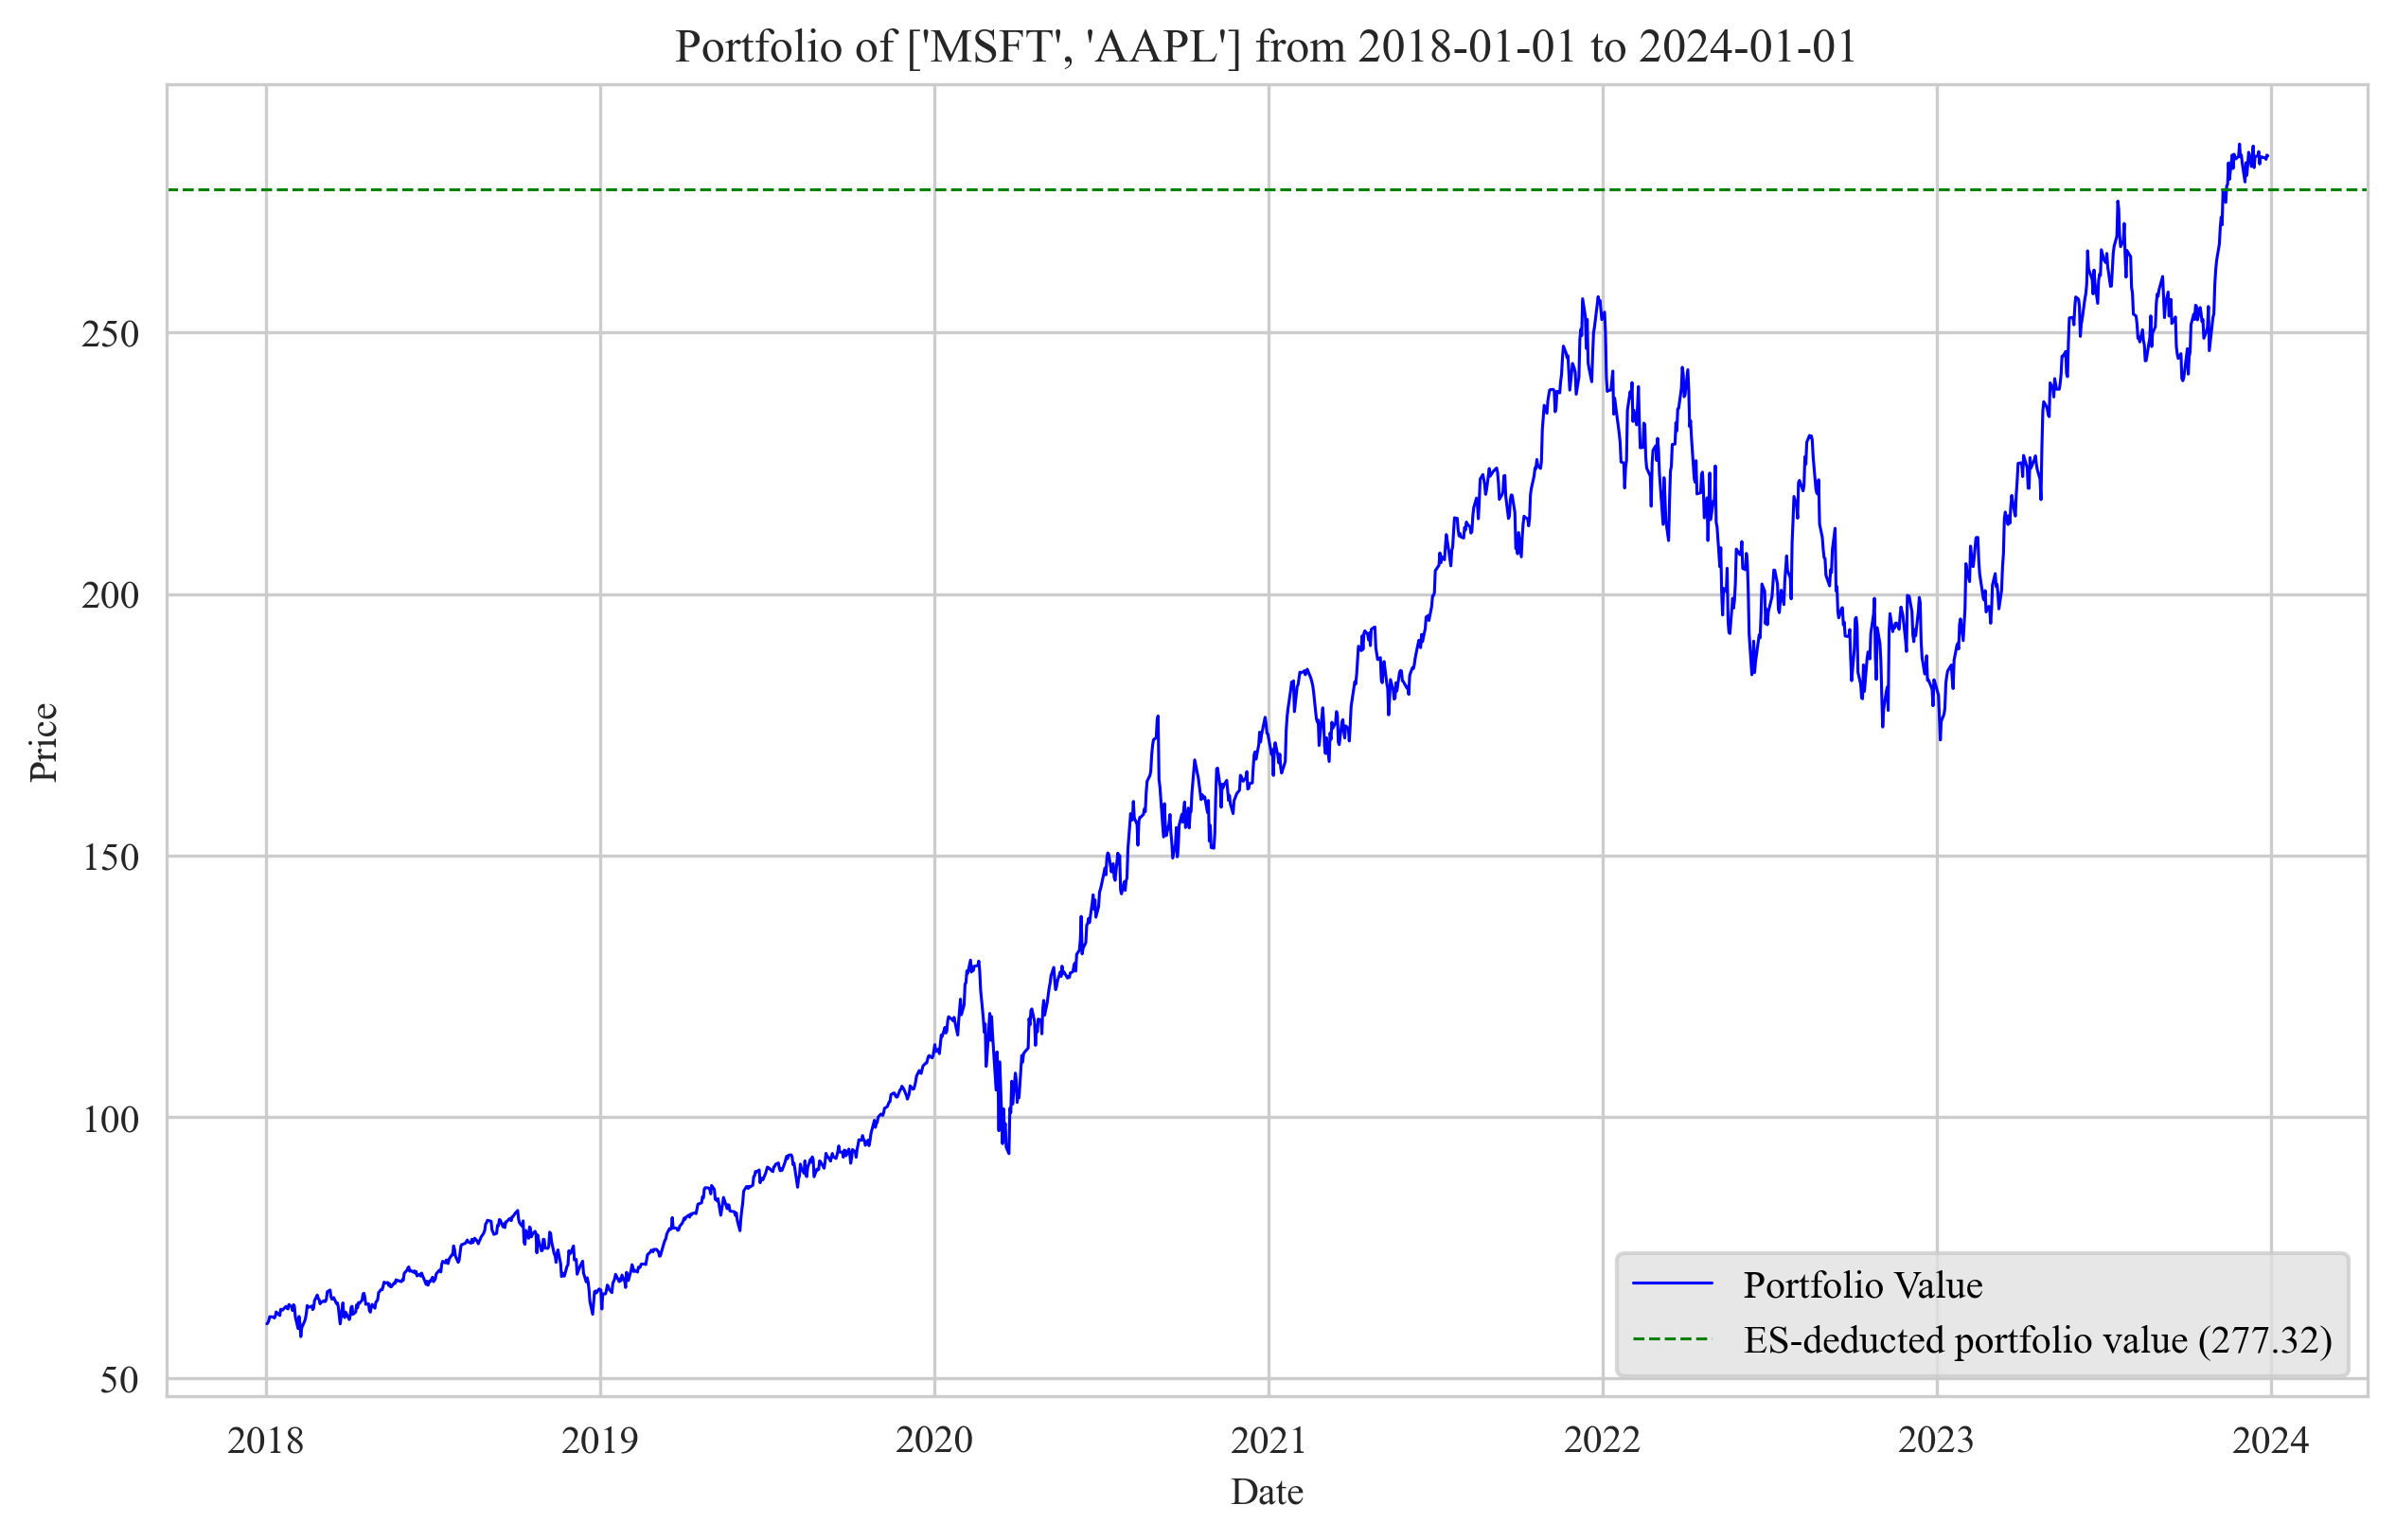

In [70]:
def Historical_ES(tickers, start_date, end_date, weights, alpha = 0.05, show_performance_metrics = False, show_visualizations = False):
    assert (0 < alpha < 1) and type(len(tickers)) is int
    data = yf.download(tickers, start_date, end_date, progress = False)["Adj Close"]
    start = tm.time()
    data["Portfolio"] = np.dot(weights, data.T)
    portfolio = data["Portfolio"]
    PnL = data["Portfolio"].diff().dropna()
    VaR = -np.quantile(PnL, alpha)
    ES = np.mean(PnL[PnL > VaR])
    end = tm.time()
    if show_performance_metrics:
        position = portfolio[-1]
        ES_position = position - ES
        computation_time = end - start
        print(f"Position size at {end_date}: {position:.2f} units of local currency")
        print(f"Significance level: \u03B1 = {alpha}")
        print(f"Time horizon: 1 day")
        print(f"Estimated ES: {ES:.2f} units of local currency")
        print(f"Estimated ES-deducted portfolio value at {end_date}: {ES_position:.2f} units of local currency")
        print(f"Computation time: {computation_time:.3f} seconds")
    else:
        pass
    if show_visualizations:
        fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
        sns.lineplot(data = portfolio, linewidth = 0.75, color = "b", label = "Portfolio Value").set(xlabel = "Date", ylabel = "Price")
        plt.axhline(ES_position, color = "green", linestyle = "--", linewidth = 0.75, label = f"ES-deducted portfolio value ({ES_position:.2f})")
        plt.legend(labelcolor = "black", facecolor = "#E1E1E1")
        plt.title(f"Portfolio of {tickers} from {start_date} to {end_date}")
        plt.show()
    else:
        pass
    return ES

ES = Historical_ES(tickers, start_date, end_date, weights, alpha, show_performance_metrics, show_visualizations)

#### **Python Implementation of the Historical Range Value-at-Risk**
The Python implementation of the historical method for estimating the Historical Range Value-at-Risk is given in the code cell below.

Position size at 2024-01-01: 283.82 units of local currency
Upper significance level: α = 0.05
Lower significance level: β = 0.01
Time horizon: 1 day
Estimated RVaR: 5.85 units of local currency
Estimated RVaR-deducted portfolio value at 2024-01-01: 277.97 units of local currency
Computation time: 0.000 seconds


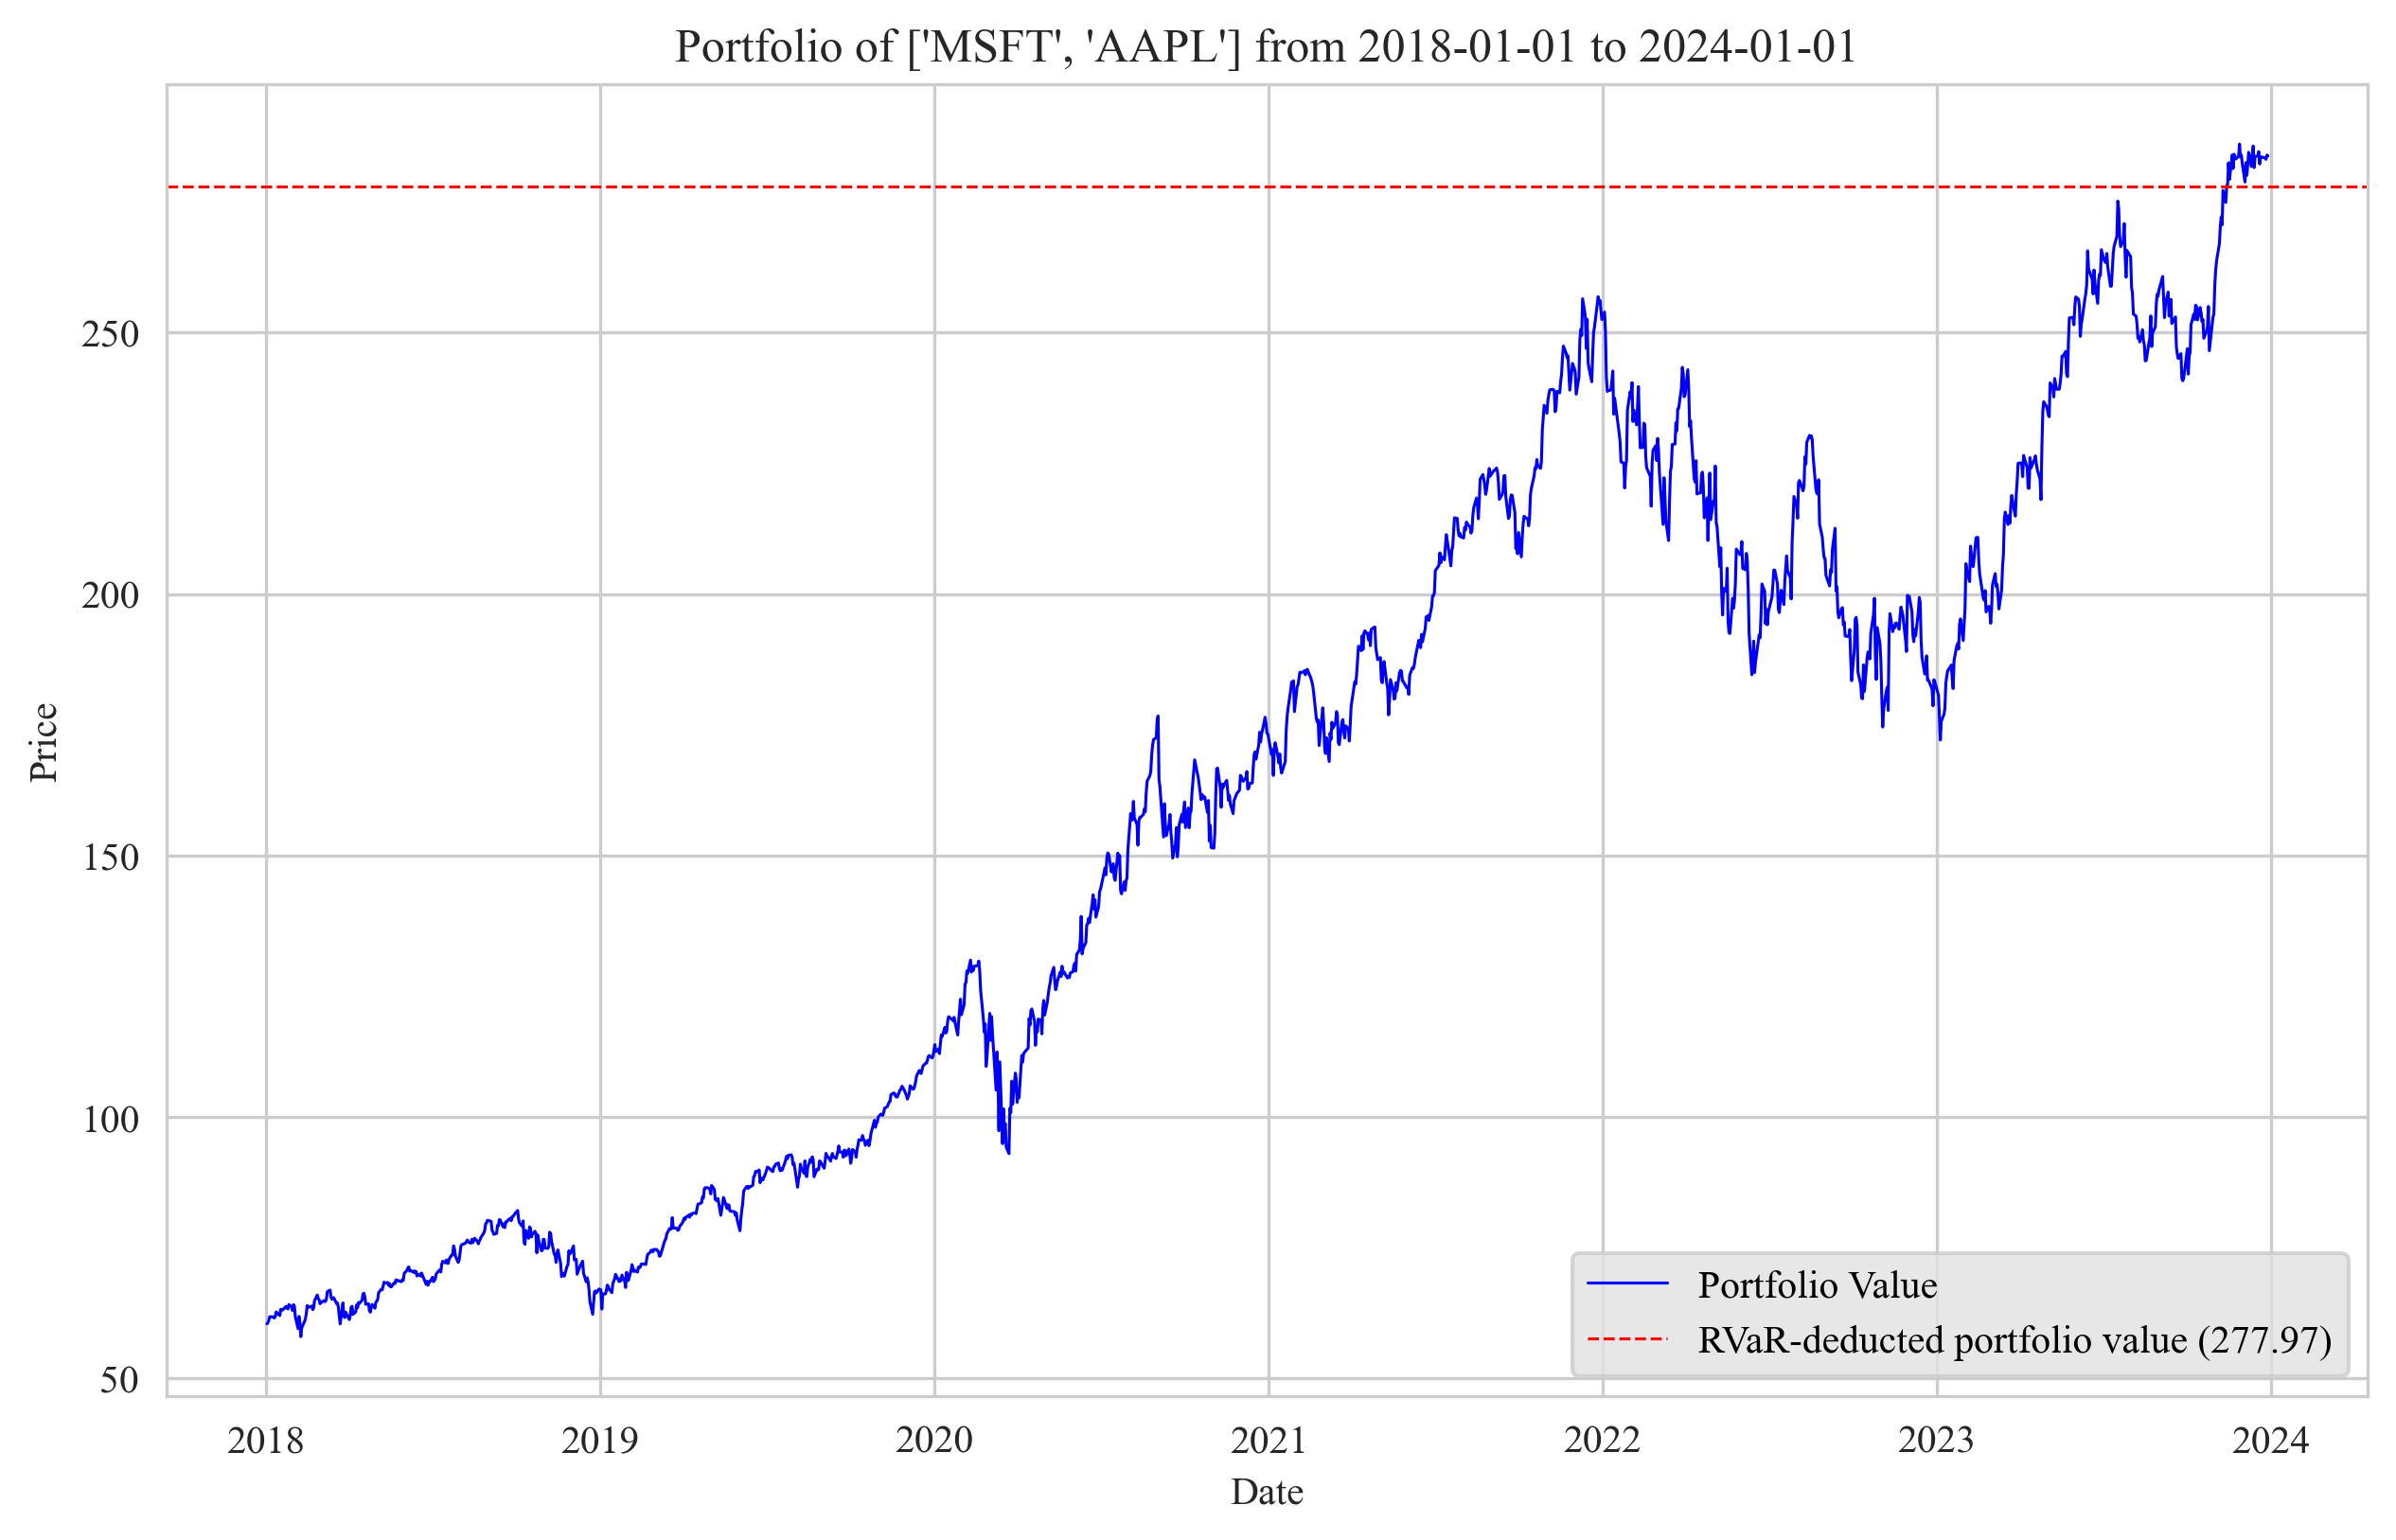

In [71]:
def Historical_RVaR(tickers, start_date, end_date, weights, alpha = 0.05, beta = 0.01, show_performance_metrics = False, show_visualizations = False):
    assert (0 < beta < alpha < 1) and type(len(tickers)) is int
    data = yf.download(tickers, start_date, end_date, progress = False)["Adj Close"]
    start = tm.time()
    data["Portfolio"] = np.dot(weights, data.T)
    portfolio = data["Portfolio"]
    PnL = data["Portfolio"].diff().dropna()
    VaR_alpha = -np.quantile(PnL, alpha)
    VaR_beta = -np.quantile(PnL, beta)
    RVaR = np.mean(PnL[(VaR_alpha < PnL) & (PnL < VaR_beta)])
    end = tm.time()
    if show_performance_metrics:
        position = portfolio[-1]
        RVaR_position = position - RVaR
        computation_time = end - start
        print(f"Position size at {end_date}: {position:.2f} units of local currency")
        print(f"Upper significance level: \u03B1 = {alpha}")
        print(f"Lower significance level: \u03B2 = {beta}")
        print(f"Time horizon: 1 day")
        print(f"Estimated RVaR: {RVaR:.2f} units of local currency")
        print(f"Estimated RVaR-deducted portfolio value at {end_date}: {RVaR_position:.2f} units of local currency")
        print(f"Computation time: {computation_time:.3f} seconds")
    else:
        pass
    if show_visualizations:
        fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
        sns.lineplot(data = portfolio, linewidth = 0.75, color = "b", label = "Portfolio Value").set(xlabel = "Date", ylabel = "Price")
        plt.axhline(RVaR_position, color = "red", linestyle = "--", linewidth = 0.75, label = f"RVaR-deducted portfolio value ({RVaR_position:.2f})")
        plt.legend(labelcolor = "black", facecolor = "#E1E1E1")
        plt.title(f"Portfolio of {tickers} from {start_date} to {end_date}")
        plt.show()
    else:
        pass
    return RVaR

RVaR = Historical_RVaR(tickers, start_date, end_date, weights, alpha, beta, show_performance_metrics, show_visualizations)

An added sanity check ensures that the results are indeed intuitively valid:

In [72]:
VaR <= RVaR <= ES

True

## **Parametric Method**
### **Application of the Parametric Method**
The general procedure of estimating the risk functions via the parametric method is similar to the analogous procedure done via historical method, but the difference is that instead of retrieving quantiles directly from the profit-and-loss distribution of the historical price data, the relevant quantiles are retireved from a *predetermined probability distribution* (usually the normal distribution) that the profit-and-loss distribution is assumed to follow. Thus, the parametric method involves calculating specific moments of the profit-and-loss distribution and using those metrics to emulate the closest resembling probability distribution. Moreover, the parametric method does make an *a priori* assumption about the profit-and-loss distribution, and subsequently retireves the quantiles of interest. For simplicity the returns process will be used and it will be assumed to have a normal distribution.

### **Python Implementation of the Parametric Method**
#### **Python Implementation of the Parametric Value-at-Risk**
The Python implementation of the historical method for estimating the Parametric Value-at-Risk is given in the code cell below.

Position size at 2024-01-01: 283.82 units of local currency
Significance level: α = 0.05
Time horizon: 1 day
Estimated VaR: 8.14 units of local currency
Estimated VaR-deducted portfolio value at 2024-01-01: 275.67 units of local currency
Computation time: 0.004 seconds


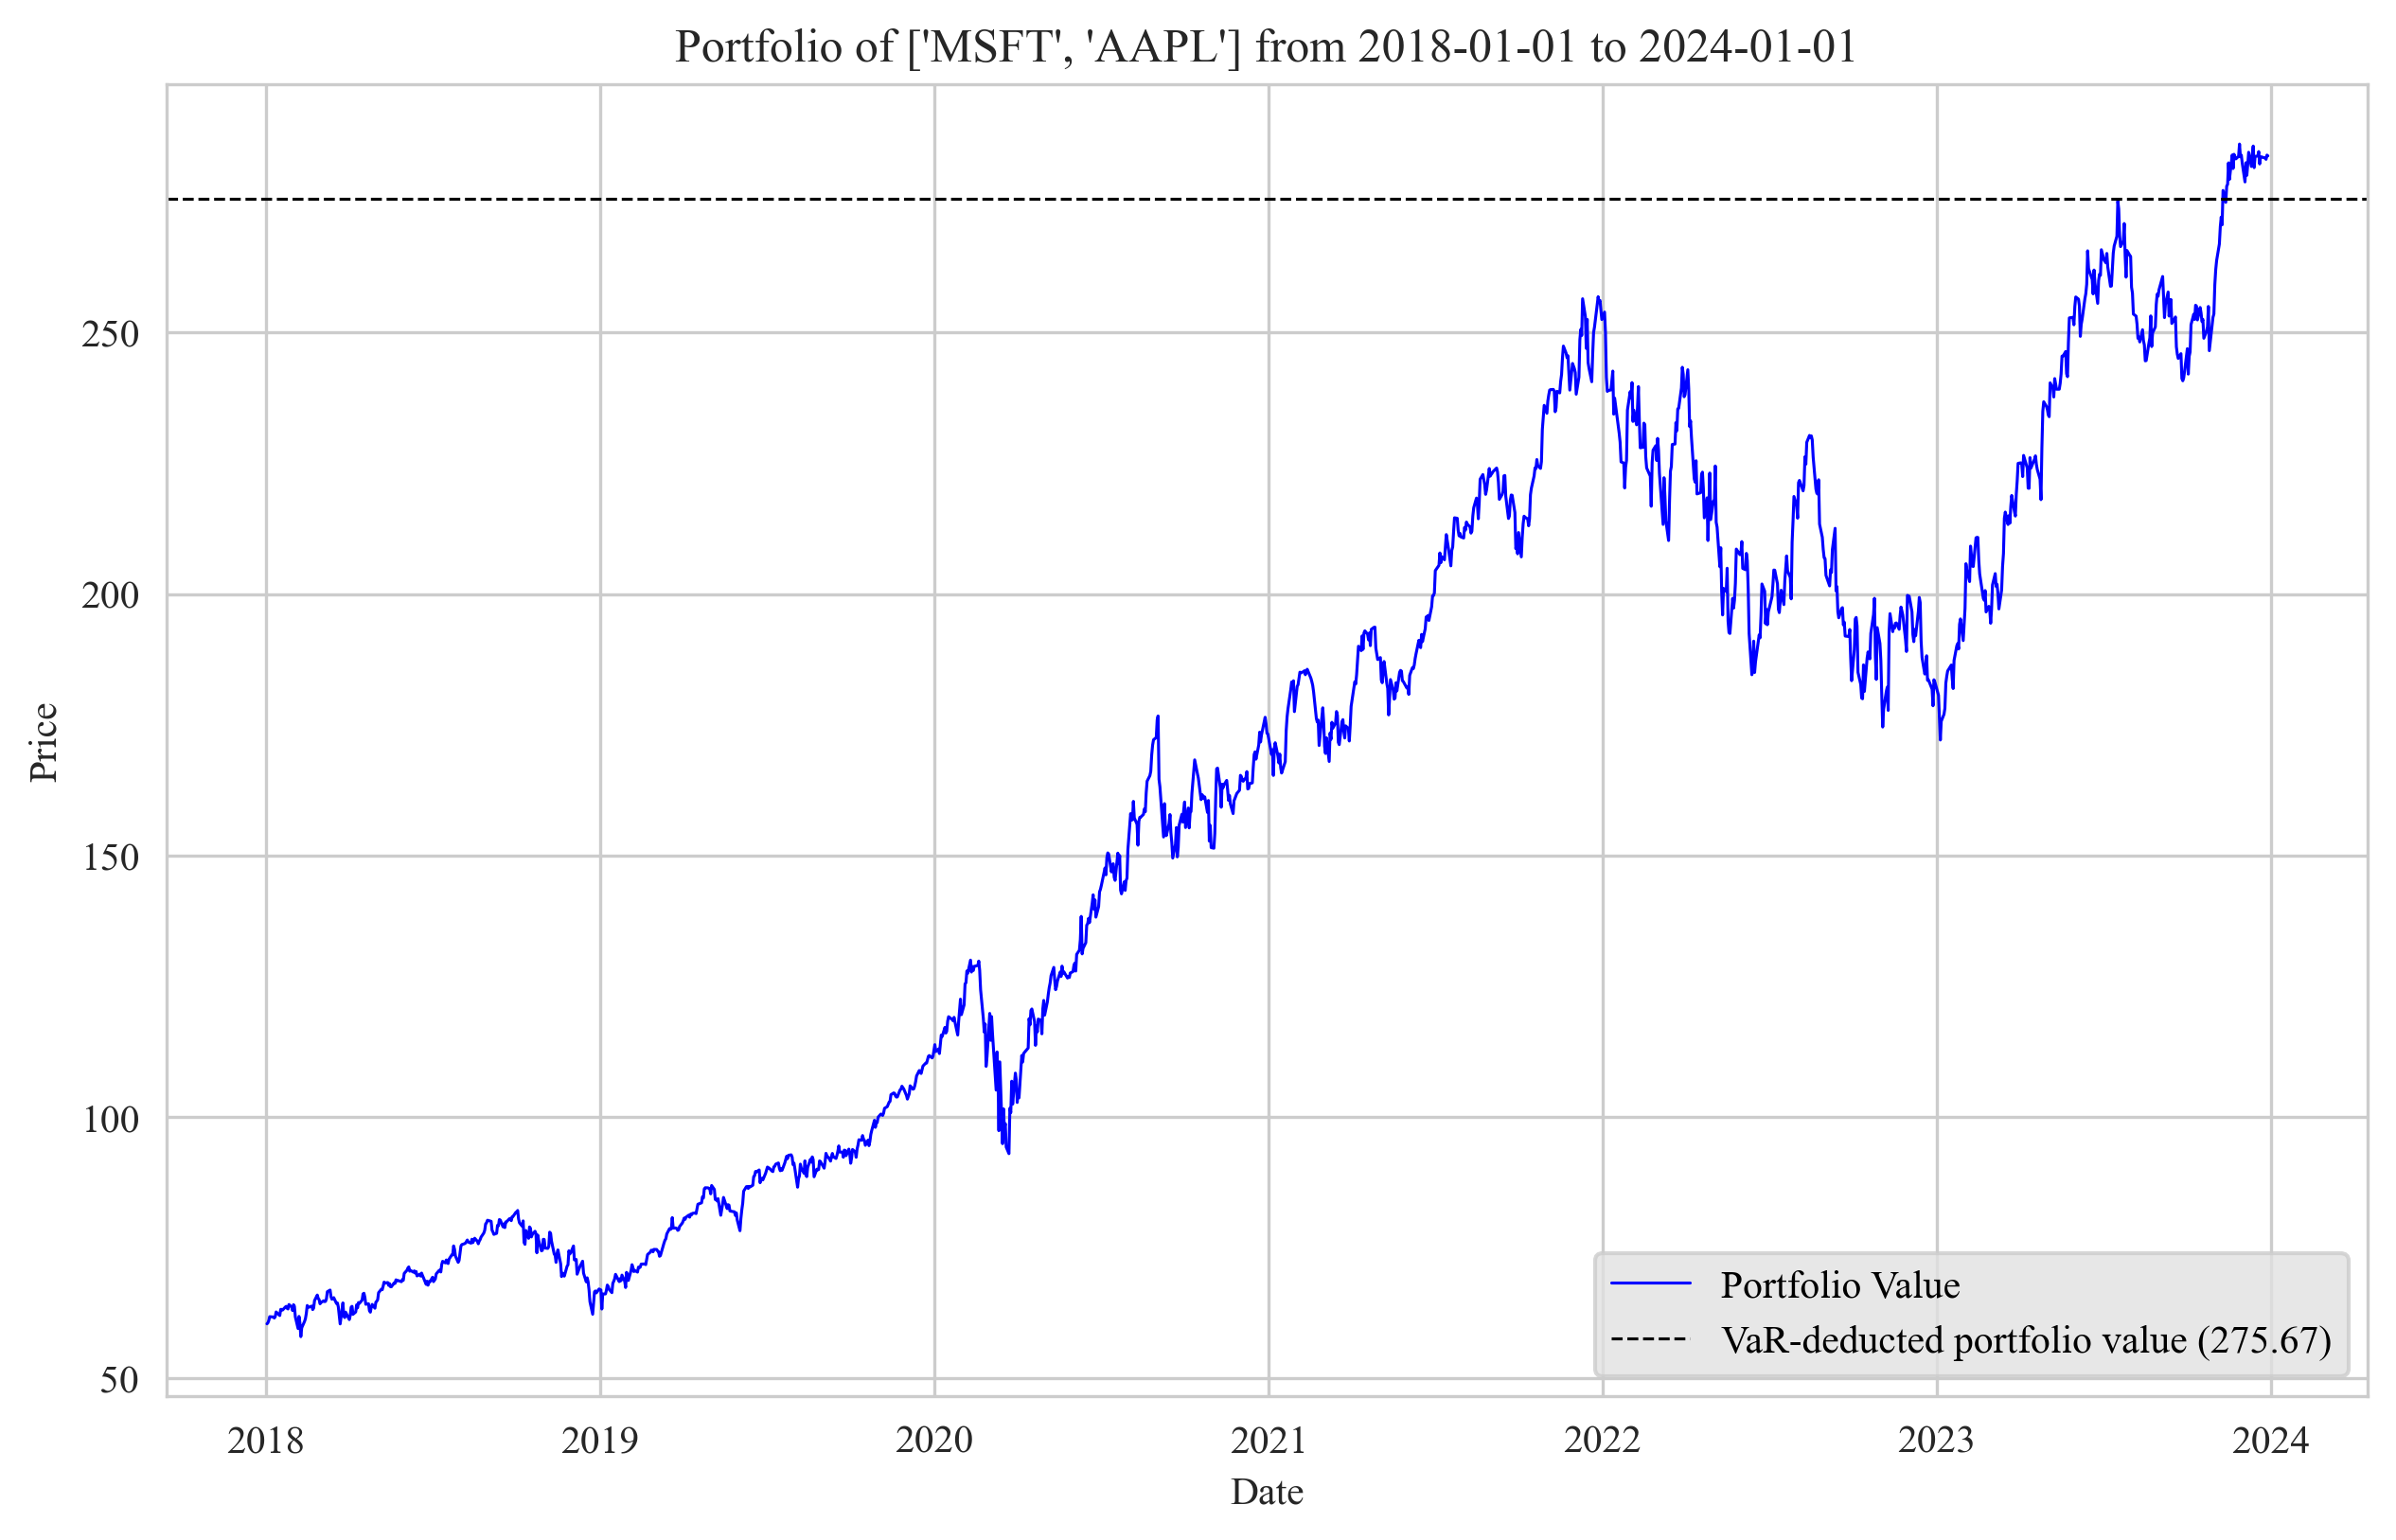

In [73]:
def Parametric_VaR(tickers, start_date, end_date, weights, alpha, show_performance_metrics = False, show_visualizations = False):
    assert (0 < alpha < 1) and type(len(tickers)) is int
    data = yf.download(tickers, start_date, end_date, progress = False)["Adj Close"]
    start = tm.time()
    data["Portfolio"] = np.dot(weights, data.T)
    portfolio = data["Portfolio"]
    returns = data["Portfolio"].pct_change().dropna()
    m = returns.mean()
    s = returns.std()
    VaR = - sp.stats.norm.ppf(alpha, loc = m, scale = s) * portfolio[-1]
    end = tm.time()
    if show_performance_metrics:
        position = portfolio[-1]
        VaR_position = position - VaR
        computation_time = end - start
        print(f"Position size at {end_date}: {position:.2f} units of local currency")
        print(f"Significance level: \u03B1 = {alpha}")
        print(f"Time horizon: 1 day")
        print(f"Estimated VaR: {VaR:.2f} units of local currency")
        print(f"Estimated VaR-deducted portfolio value at {end_date}: {VaR_position:.2f} units of local currency")
        print(f"Computation time: {computation_time:.3f} seconds")
    else:
        pass
    if show_visualizations:
        fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
        sns.lineplot(data = portfolio, linewidth = 0.75, color = "b", label = "Portfolio Value").set(xlabel = "Date", ylabel = "Price")
        plt.axhline(VaR_position, color = "black", linestyle = "--", linewidth = 0.75, label = f"VaR-deducted portfolio value ({VaR_position:.2f})")
        plt.legend(labelcolor = "black", facecolor = "#E1E1E1")
        plt.title(f"Portfolio of {tickers} from {start_date} to {end_date}")
        plt.show()
    else:
        pass
    return VaR

VaR = Parametric_VaR(tickers, start_date, end_date, weights, alpha, show_performance_metrics, show_visualizations)

#### **Python Implementation of the Parametric Expected Shortfall**
The Python implementation of the historical method for estimating the Parametric Expected Shortfall is given in the code cell below.

Position size at 2024-01-01: 283.82 units of local currency
Significance level: α = 0.05
Time horizon: 1 day
Estimated ES: 10.29 units of local currency
Estimated ES-deducted portfolio value at 2024-01-01: 273.52 units of local currency
Computation time: 0.092 seconds


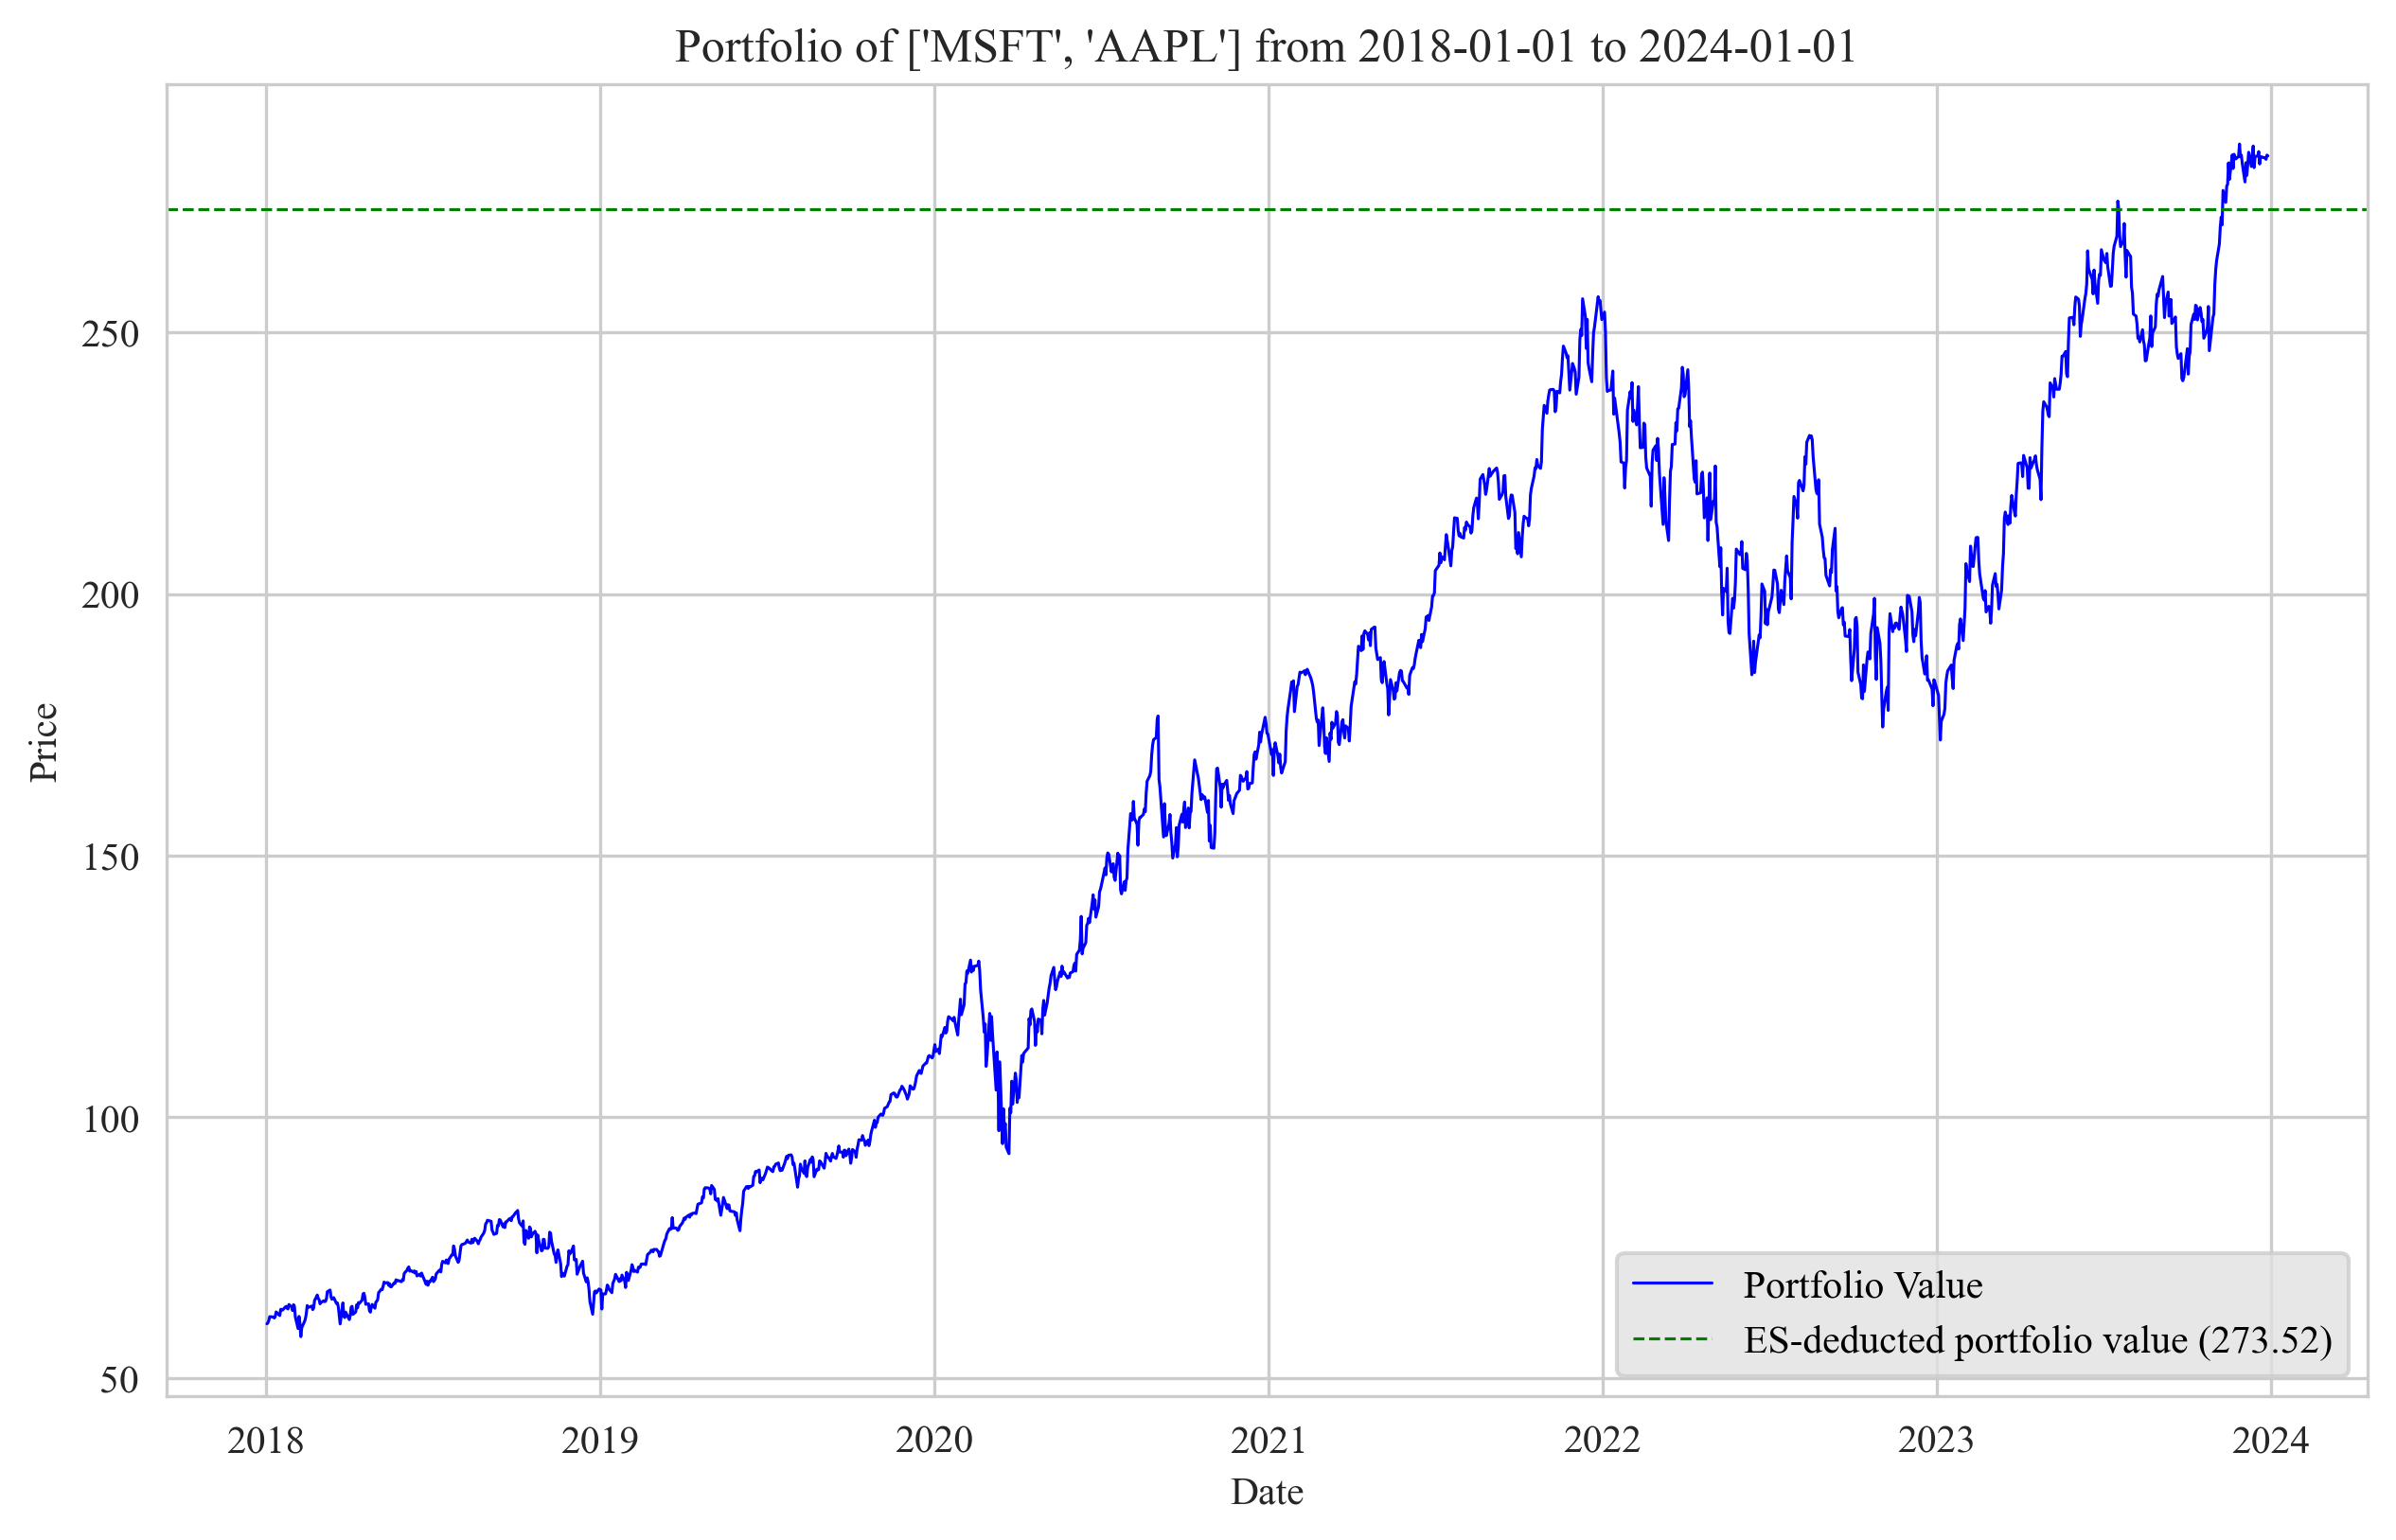

In [74]:
def Parametric_ES(tickers, start_date, end_date, weights, alpha, show_performance_metrics = False, show_visualizations = False):
    assert (0 < alpha < 1) and type(len(tickers)) is int
    data = yf.download(tickers, start_date, end_date, progress = False)["Adj Close"]
    start = tm.time()
    data["Portfolio"] = np.dot(weights, data.T)
    portfolio = data["Portfolio"]
    returns = data["Portfolio"].pct_change().dropna()
    m = returns.mean()
    s = returns.std()
    VaR = lambda gamma: sp.stats.norm.ppf(gamma, loc = m, scale = s) * portfolio[-1]
    ES = - (1 / alpha) * sp.integrate.quad(VaR, 0, alpha)[0]
    end = tm.time()
    if show_performance_metrics:
        position = portfolio[-1]
        ES_position = position - ES
        computation_time = end - start
        print(f"Position size at {end_date}: {position:.2f} units of local currency")
        print(f"Significance level: \u03B1 = {alpha}")
        print(f"Time horizon: 1 day")
        print(f"Estimated ES: {ES:.2f} units of local currency")
        print(f"Estimated ES-deducted portfolio value at {end_date}: {ES_position:.2f} units of local currency")
        print(f"Computation time: {computation_time:.3f} seconds")
    else:
        pass
    if show_visualizations:
        fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
        sns.lineplot(data = portfolio, linewidth = 0.75, color = "b", label = "Portfolio Value").set(xlabel = "Date", ylabel = "Price")
        plt.axhline(ES_position, color = "green", linestyle = "--", linewidth = 0.75, label = f"ES-deducted portfolio value ({ES_position:.2f})")
        plt.legend(labelcolor = "black", facecolor = "#E1E1E1")
        plt.title(f"Portfolio of {tickers} from {start_date} to {end_date}")
        plt.show()
    else:
        pass
    return ES

ES = Parametric_ES(tickers, start_date, end_date, weights, alpha, show_performance_metrics, show_visualizations)

#### **Python Implementation of the Parametric Range Value-at-Risk**
The Python implementation of the historical method for estimating the Parametric Range Value-at-Risk is given in the code cell below.

Position size at 2024-01-01: 283.82 units of local currency
Upper significance level: α = 0.05
Lower significance level: β = 0.01
Time horizon: 1 day
Estimated RVaR: 9.52 units of local currency
Estimated RVaR-deducted portfolio value at 2024-01-01: 274.30 units of local currency
Computation time: 0.008 seconds


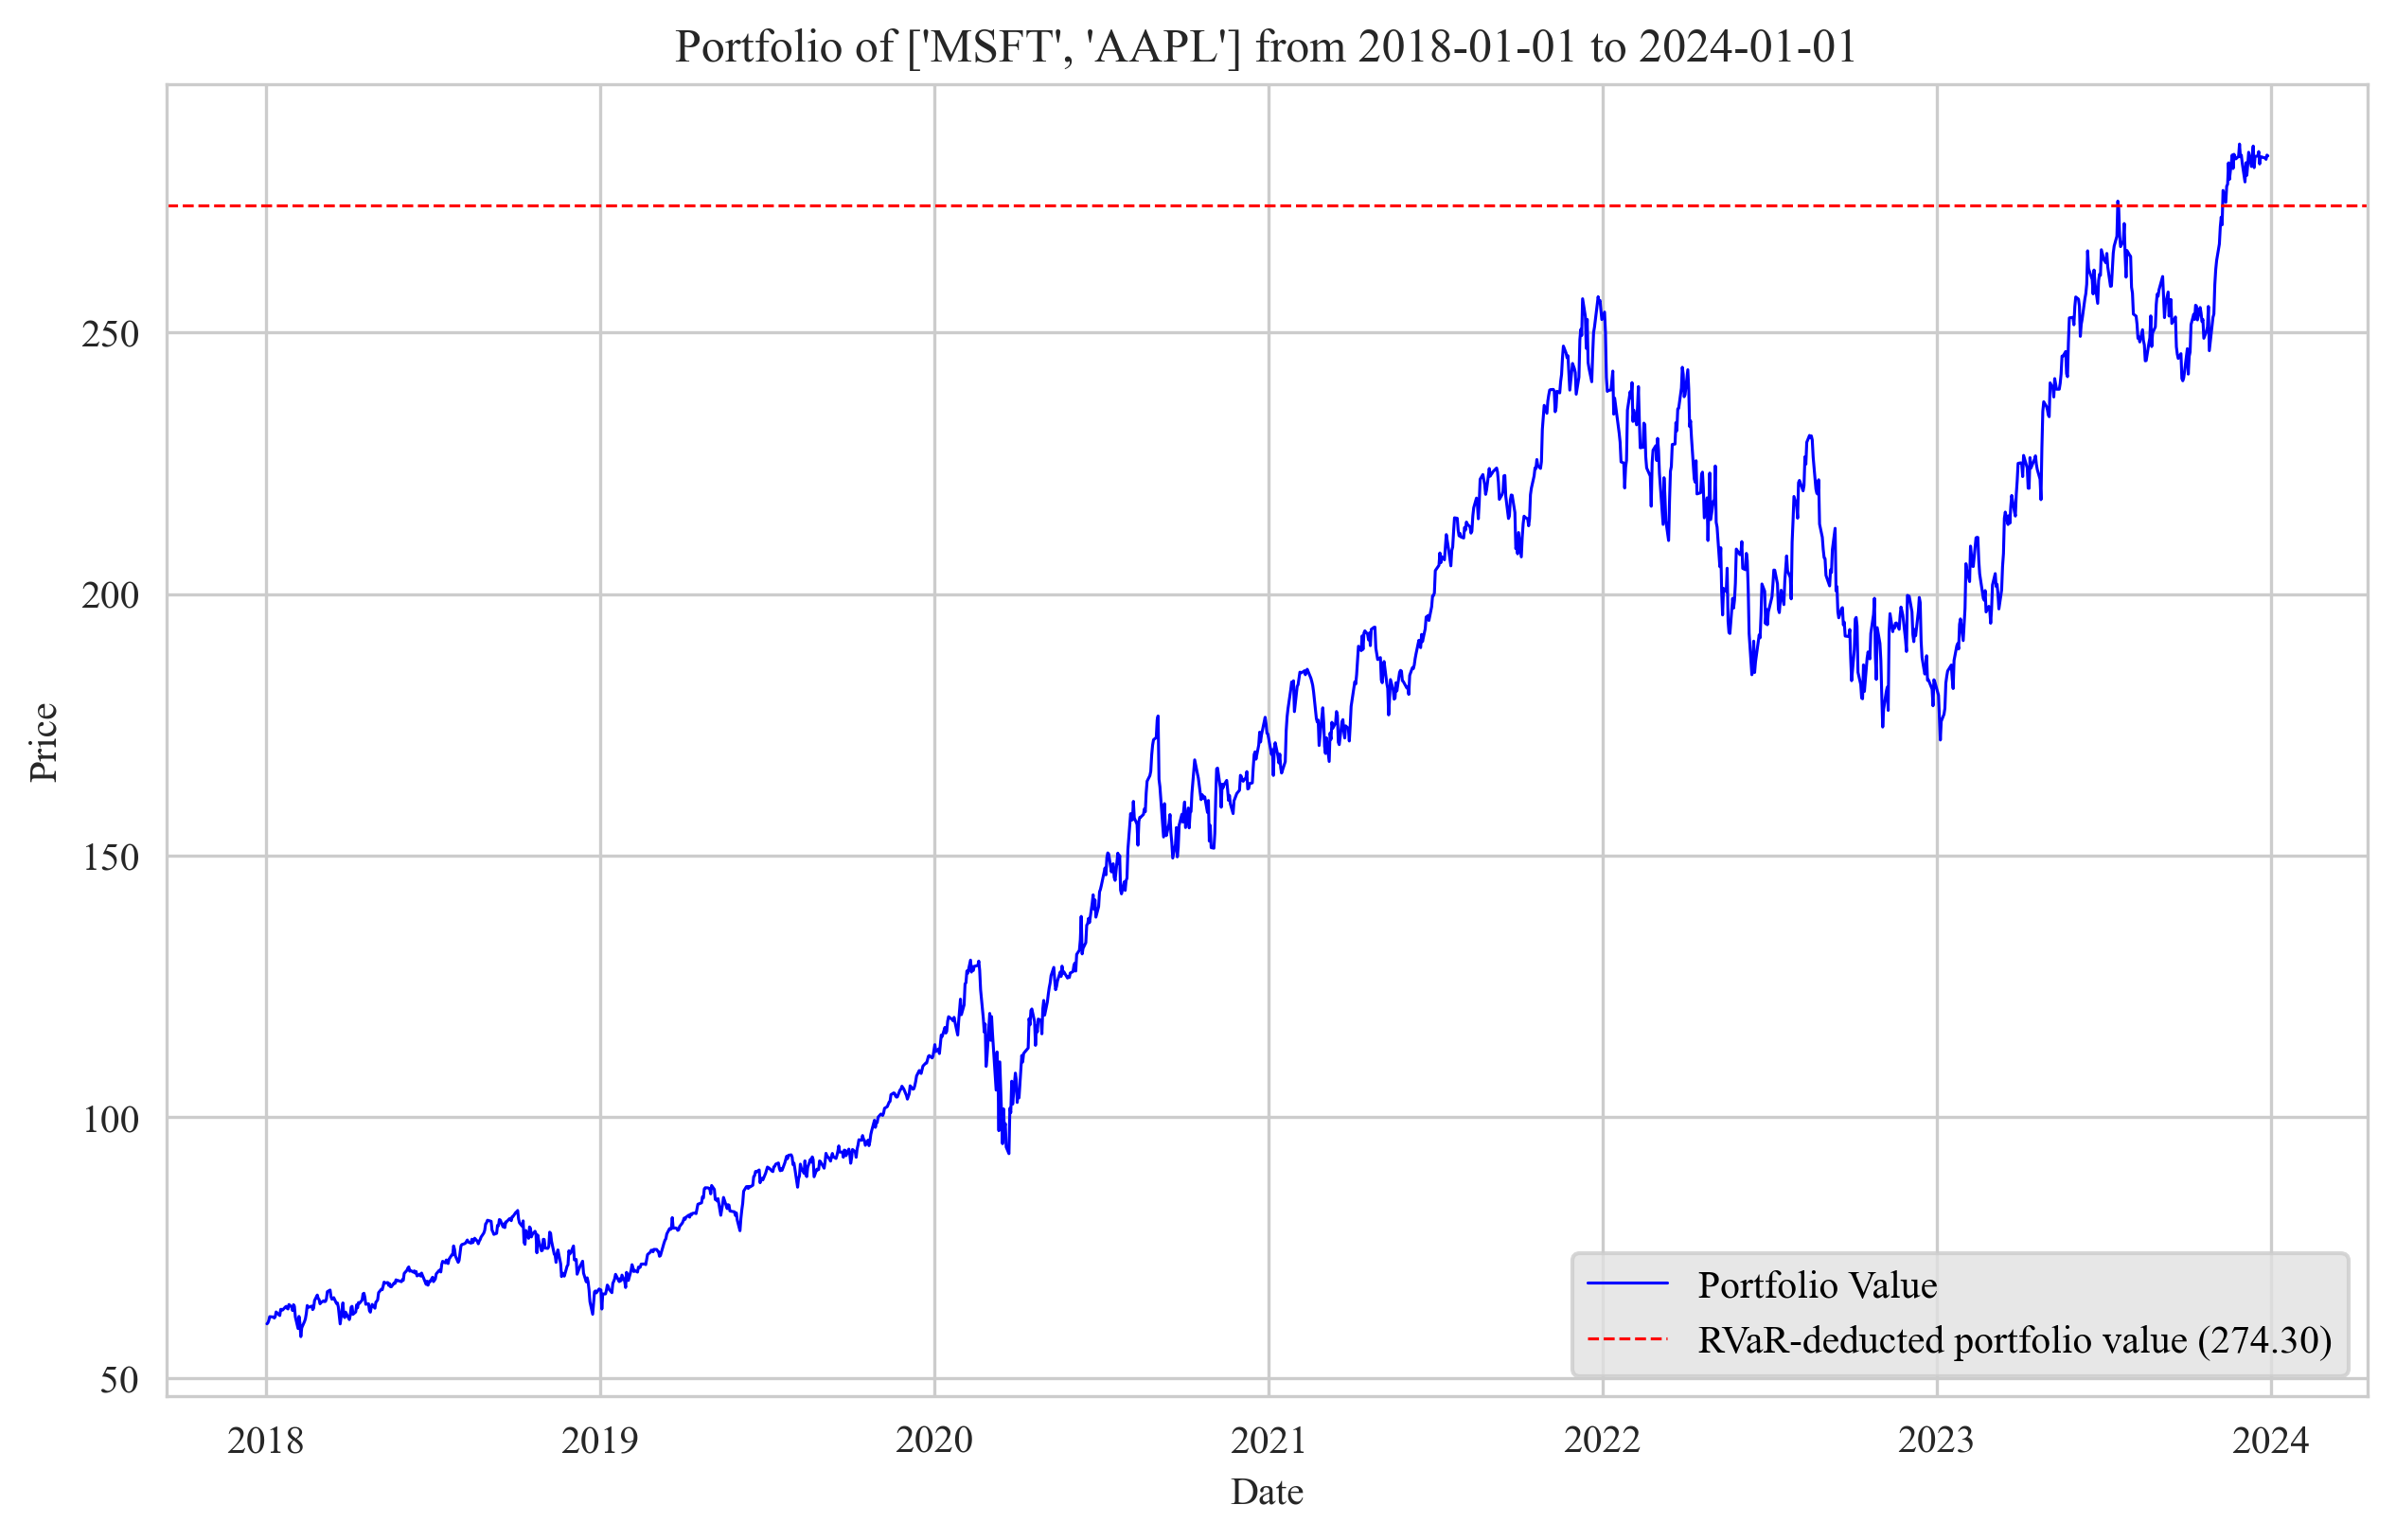

In [75]:
def Parametric_RVaR(tickers, start_date, end_date, weights, alpha, beta, show_performance_metrics = False, show_visualizations = False):
    assert (0 < beta < alpha < 1) and type(len(tickers)) is int
    data = yf.download(tickers, start_date, end_date, progress = False)["Adj Close"]
    start = tm.time()
    data["Portfolio"] = np.dot(weights, data.T)
    portfolio = data["Portfolio"]
    returns = data["Portfolio"].pct_change().dropna()
    m = returns.mean()
    s = returns.std()
    VaR = lambda gamma: sp.stats.norm.ppf(gamma, loc = m, scale = s) * portfolio[-1]
    RVaR = - (1 / (alpha - beta)) * sp.integrate.quad(VaR, beta, alpha)[0]
    end = tm.time()
    if show_performance_metrics:
        position = portfolio[-1]
        RVaR_position = position - RVaR
        computation_time = end - start
        print(f"Position size at {end_date}: {position:.2f} units of local currency")
        print(f"Upper significance level: \u03B1 = {alpha}")
        print(f"Lower significance level: \u03B2 = {beta}")
        print(f"Time horizon: 1 day")
        print(f"Estimated RVaR: {RVaR:.2f} units of local currency")
        print(f"Estimated RVaR-deducted portfolio value at {end_date}: {RVaR_position:.2f} units of local currency")
        print(f"Computation time: {computation_time:.3f} seconds")
    else:
        pass
    if show_visualizations:
        fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
        sns.lineplot(data = portfolio, linewidth = 0.75, color = "b", label = "Portfolio Value").set(xlabel = "Date", ylabel = "Price")
        plt.axhline(RVaR_position, color = "red", linestyle = "--", linewidth = 0.75, label = f"RVaR-deducted portfolio value ({RVaR_position:.2f})")
        plt.legend(labelcolor = "black", facecolor = "#E1E1E1")
        plt.title(f"Portfolio of {tickers} from {start_date} to {end_date}")
        plt.show()
    else:
        pass
    return RVaR

RVaR = Parametric_RVaR(tickers, start_date, end_date, weights, alpha, beta, show_performance_metrics, show_visualizations)

The same sanity check which was made for the historical method can be repeated here:

In [76]:
VaR <= RVaR <= ES

True

## **Monte Carlo Method**
### **Application of the Monte Carlo Method**
### **Python Implementation of the Monte Carlo Method**

## **Credits**
* Wikipedia contributors, "[Value at risk](https://en.wikipedia.org/w/index.php?title=Value_at_risk&oldid=1207006629)," Wikipedia, The Free Encyclopedia (accessed February 29, 2024).
* Wikipedia contributors, "[Expected shortfall](https://en.wikipedia.org/w/index.php?title=Expected_shortfall&oldid=1191488388)," Wikipedia, The Free Encyclopedia (accessed February 29, 2024).
* The original code is provided as-is in this project by Zakaria Zerrouki